**CHAPTER 5 Data Warehouse**

**5.1 Import via bq command with BashOperator on Airflow**

In [ ]:
from airflow.models import DAG
from airflow.decorators import dag, task
from airflow.operators.bash import BashOperator
from airflow.providers.mysql.hooks.mysql import MySqlHook
from airflow.utils.dates import days_ago
import pandas as pd
import requests

MYSQL_CONNECTION = "mysql_default"   # Name of the connection configured in Airflow
CONVERSION_RATE_URL = "https://r2de3-currency-api-vmftiryt6q-as.a.run.app/gbp_thb"

# Variable for output_path to save
mysql_output_path = "/home/airflow/gcs/data/transaction_data_merged.parquet"
conversion_rate_output_path = "/home/airflow/gcs/data/conversion_rate.parquet"
final_output_path = "/home/airflow/gcs/data/workshop4_output.parquet"

default_args = {
    'owner': 'datath',
}

@task()
def get_data_from_mysql(output_path):
    # Receive output_path from the calling task
    # Use MySqlHook to connect to MySQL from the connection configured in Airflow
    mysqlserver = MySqlHook(MYSQL_CONNECTION)

    # Query from the database using the created Hook, result in pandas DataFrame
    product = mysqlserver.get_pandas_df(sql="SELECT * FROM r2de3.product")
    customer = mysqlserver.get_pandas_df(sql="SELECT * FROM r2de3.customer")
    transaction = mysqlserver.get_pandas_df(sql="SELECT * FROM r2de3.transaction")

    # Merge data from 2 DataFrames like in workshop1
    merged_transaction = transaction.merge(product, how="left", left_on="ProductNo", right_on="ProductNo").merge(customer, how="left", left_on="CustomerNo", right_on="CustomerNo")

    # Save parquet file to the received output_path
    # It will automatically go to GCS
    merged_transaction.to_parquet(output_path, index=False)
    print(f"Output to {output_path}")

@task()
def get_conversion_rate(output_path):
    # Send request to get data from CONVERSION_RATE_URL
    r = requests.get(CONVERSION_RATE_URL)
    result_conversion_rate = r.json()
    df = pd.DataFrame(result_conversion_rate)
    df = df.drop(columns=['id'])

    # Convert column to date and save parquet file
    df['date'] = pd.to_datetime(df['date'])
    df.to_parquet(output_path, index=False)
    print(f"Output to {output_path}")

@task()
def merge_data(transaction_path, conversion_rate_path, output_path):
    # Read from file using path from parameters
    transaction = pd.read_parquet(transaction_path)
    conversion_rate = pd.read_parquet(conversion_rate_path)

    # Merge 2 DataFrames
    final_df = transaction.merge(conversion_rate, how="left", left_on="Date", right_on="date")

    # Convert prices to total_amount and thb_amount
    final_df["total_amount"] = final_df["Price"] * final_df["Quantity"]
    final_df["thb_amount"] = final_df["total_amount"] * final_df["gbp_thb"]

    # Drop unused columns and rename columns
    final_df = final_df.drop(["date", "gbp_thb"], axis=1)
    final_df.columns = ['transaction_id', 'date', 'product_id', 'price', 'quantity', 'customer_id',
        'product_name', 'customer_country', 'customer_name', 'total_amount','thb_amount']

    # Save Parquet file
    final_df.to_parquet(output_path, index=False)
    print(f"Output to {output_path}")
    print("== End of Workshop 4 ʕ•́ᴥ•̀ʔっ♡ ==")

@dag(default_args=default_args, schedule_interval="@once", start_date=days_ago(1), tags=["workshop"])
def workshop5_bash():
    """
    # Workshop 5
    In this workshop, we will load data into BigQuery using the bash command (bq_load) via BashOperator
    """
    t1 = get_data_from_mysql(output_path=mysql_output_path)
    t2 = get_conversion_rate(output_path=conversion_rate_output_path)
    t3 = merge_data(
        transaction_path=mysql_output_path,
        conversion_rate_path=conversion_rate_output_path,
        output_path=final_output_path
    )

    # Create t4 using BashOperator to load into BigQuery and set dependencies
    t4 = BashOperator(
        task_id="bq_load",
        bash_command="bq load --source_format=PARQUET workshop.transaction1 gs://us-central1-workshop5-d28eb364-bucket/data/workshop4_output.parquet" ,
    )
    [t1, t2] >> t3 >> t4

workshop5_bash()

**5.2 Import via GCSToBigQeryOperator on Airflow**

In [ ]:
from airflow.models import DAG
from airflow.decorators import dag, task
from airflow.providers.google.cloud.transfers.gcs_to_bigquery import GCSToBigQueryOperator
from airflow.providers.mysql.hooks.mysql import MySqlHook
from airflow.utils.dates import days_ago
import pandas as pd
import requests

MYSQL_CONNECTION = "mysql_default"   # Name of the connection configured in Airflow
CONVERSION_RATE_URL = "https://r2de3-currency-api-vmftiryt6q-as.a.run.app/gbp_thb"

# Variable for output_path to save
mysql_output_path = "/home/airflow/gcs/data/transaction_data_merged.parquet"
conversion_rate_output_path = "/home/airflow/gcs/data/conversion_rate.parquet"
final_output_path = "/home/airflow/gcs/data/workshop4_output.parquet"

default_args = {
    'owner': 'datath',
}

@task()
def get_data_from_mysql(output_path):
    # Receive output_path from the calling task
    # Use MySqlHook to connect to MySQL from the connection configured in Airflow
    mysqlserver = MySqlHook(MYSQL_CONNECTION)

    # Query from the database using the created Hook, result in pandas DataFrame
    product = mysqlserver.get_pandas_df(sql="SELECT * FROM r2de3.product")
    customer = mysqlserver.get_pandas_df(sql="SELECT * FROM r2de3.customer")
    transaction = mysqlserver.get_pandas_df(sql="SELECT * FROM r2de3.transaction")

    # Merge data from 2 DataFrames like in workshop1
    merged_transaction = transaction.merge(product, how="left", left_on="ProductNo", right_on="ProductNo").merge(customer, how="left", left_on="CustomerNo", right_on="CustomerNo")

    # Save parquet file to the received output_path
    # It will automatically go to GCS
    merged_transaction.to_parquet(output_path, index=False)
    print(f"Output to {output_path}")

@task()
def get_conversion_rate(output_path):
    # Send request to get data from CONVERSION_RATE_URL
    r = requests.get(CONVERSION_RATE_URL)
    result_conversion_rate = r.json()
    df = pd.DataFrame(result_conversion_rate)
    df = df.drop(columns=['id'])

    # Convert column to date and save parquet file
    df['date'] = pd.to_datetime(df['date'])
    df.to_parquet(output_path, index=False)
    print(f"Output to {output_path}")

@task()
def merge_data(transaction_path, conversion_rate_path, output_path):
    # Read from file using path from parameters
    transaction = pd.read_parquet(transaction_path)
    conversion_rate = pd.read_parquet(conversion_rate_path)

    # Merge 2 DataFrames
    final_df = transaction.merge(conversion_rate, how="left", left_on="Date", right_on="date")

    # Convert prices to total_amount and thb_amount
    final_df["total_amount"] = final_df["Price"] * final_df["Quantity"]
    final_df["thb_amount"] = final_df["total_amount"] * final_df["gbp_thb"]

    # Drop unused columns and rename columns
    final_df = final_df.drop(["date", "gbp_thb"], axis=1)
    final_df.columns = ['transaction_id', 'date', 'product_id', 'price', 'quantity', 'customer_id',
        'product_name', 'customer_country', 'customer_name', 'total_amount','thb_amount']

    # Save Parquet file
    final_df.to_parquet(output_path, index=False)
    print(f"Output to {output_path}")
    print("== End of Workshop 4 ʕ•́ᴥ•̀ʔっ♡ ==")

@dag(default_args=default_args, schedule_interval="@once", start_date=days_ago(1), tags=["workshop"])
def workshop5():
    """
    # Workshop 5
    In this workshop, we will load data into BigQuery using Airflow’s GCSToBigQueryOperator
    """
    t1 = get_data_from_mysql(output_path=mysql_output_path)
    t2 = get_conversion_rate(output_path=conversion_rate_output_path)
    t3 = merge_data(
        transaction_path=mysql_output_path,
        conversion_rate_path=conversion_rate_output_path,
        output_path=final_output_path
    )

    # Create t4 using GCSToBigQueryOperator to load into BigQuery via Airflow and set dependencies
    t4 = GCSToBigQueryOperator(
        task_id="gcs_to_bigquery",
        bucket="us-central1-workshop5-d28eb364-bucket",
        source_objects=["data/workshop4_output.parquet"],
        source_format="PARQUET",
        destination_project_dataset_table="workshop.transaction",
        write_disposition="WRITE_TRUNCATE"
    )
    [t1, t2] >> t3 >> t4

workshop5()

**Appendix**

A. Create dataset in BigQuery

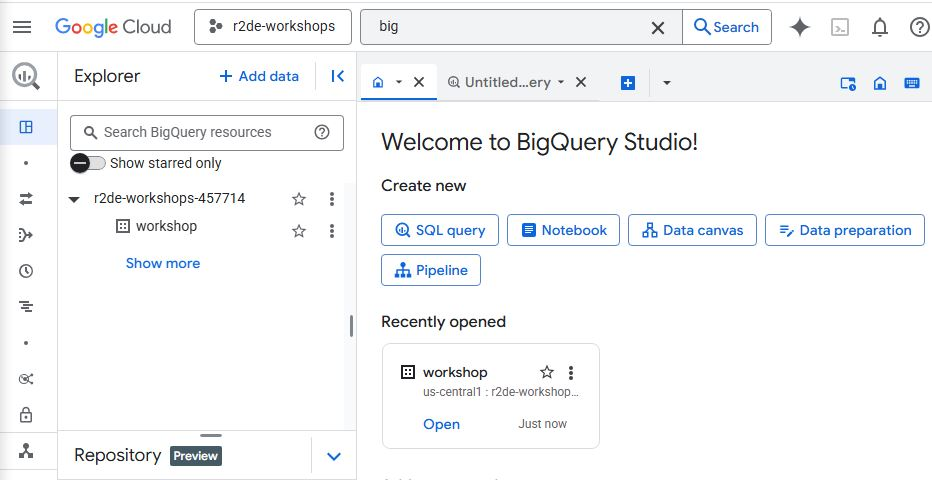

B. Import via bq command with BashOperator on Airflow

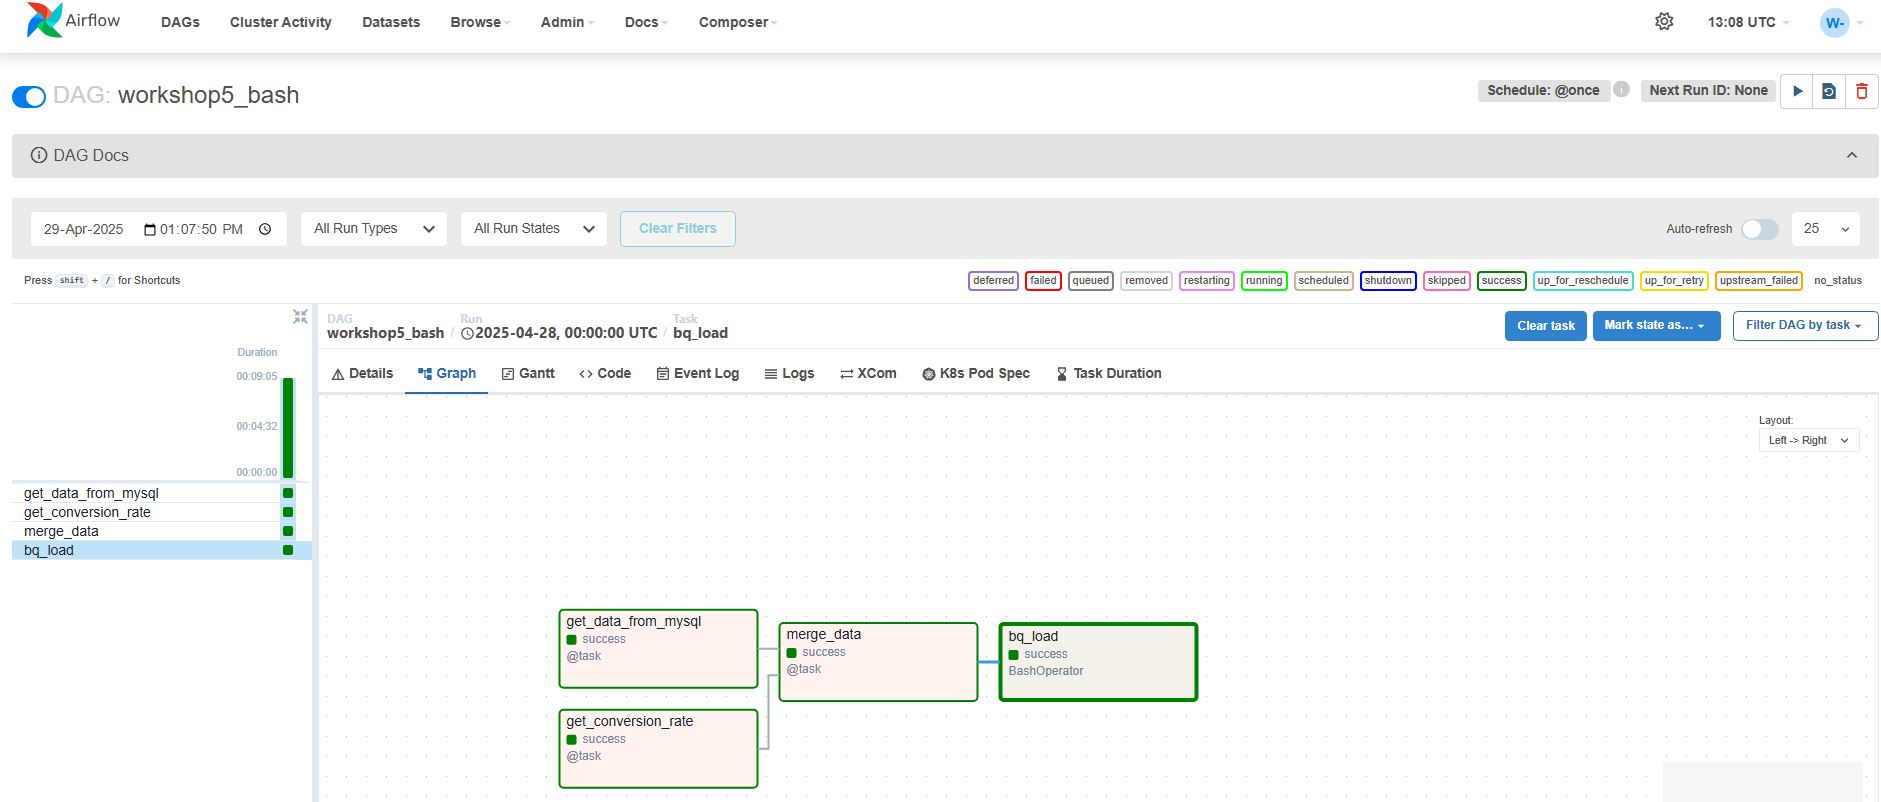

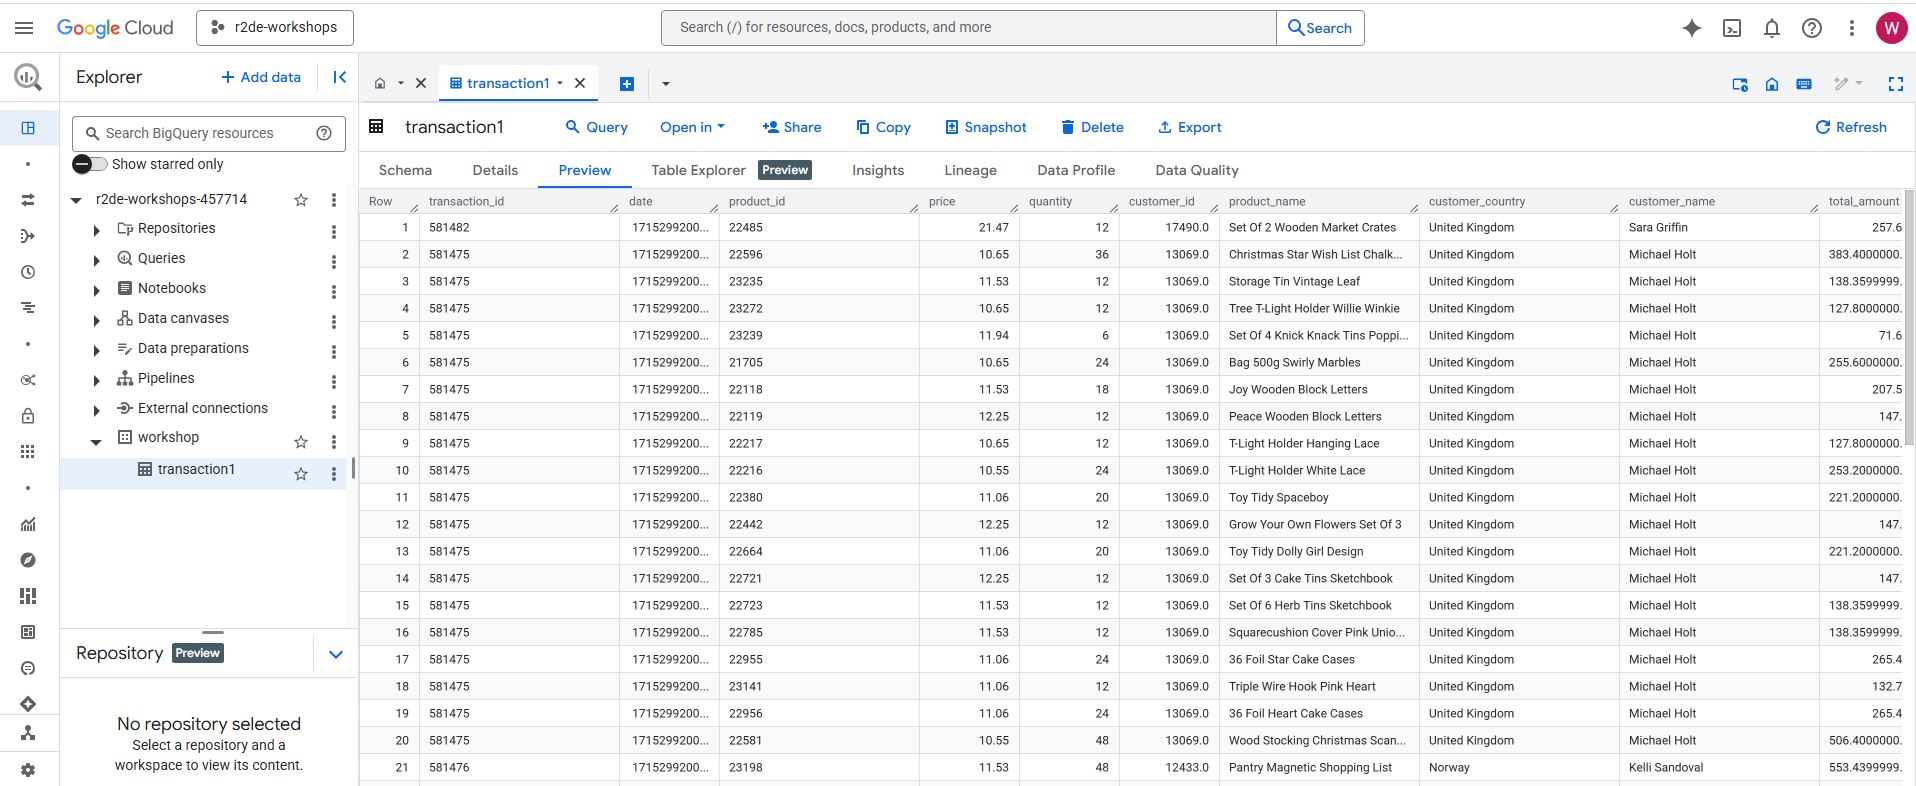

C. Import via GCSToBigQeryOperator on Airflow

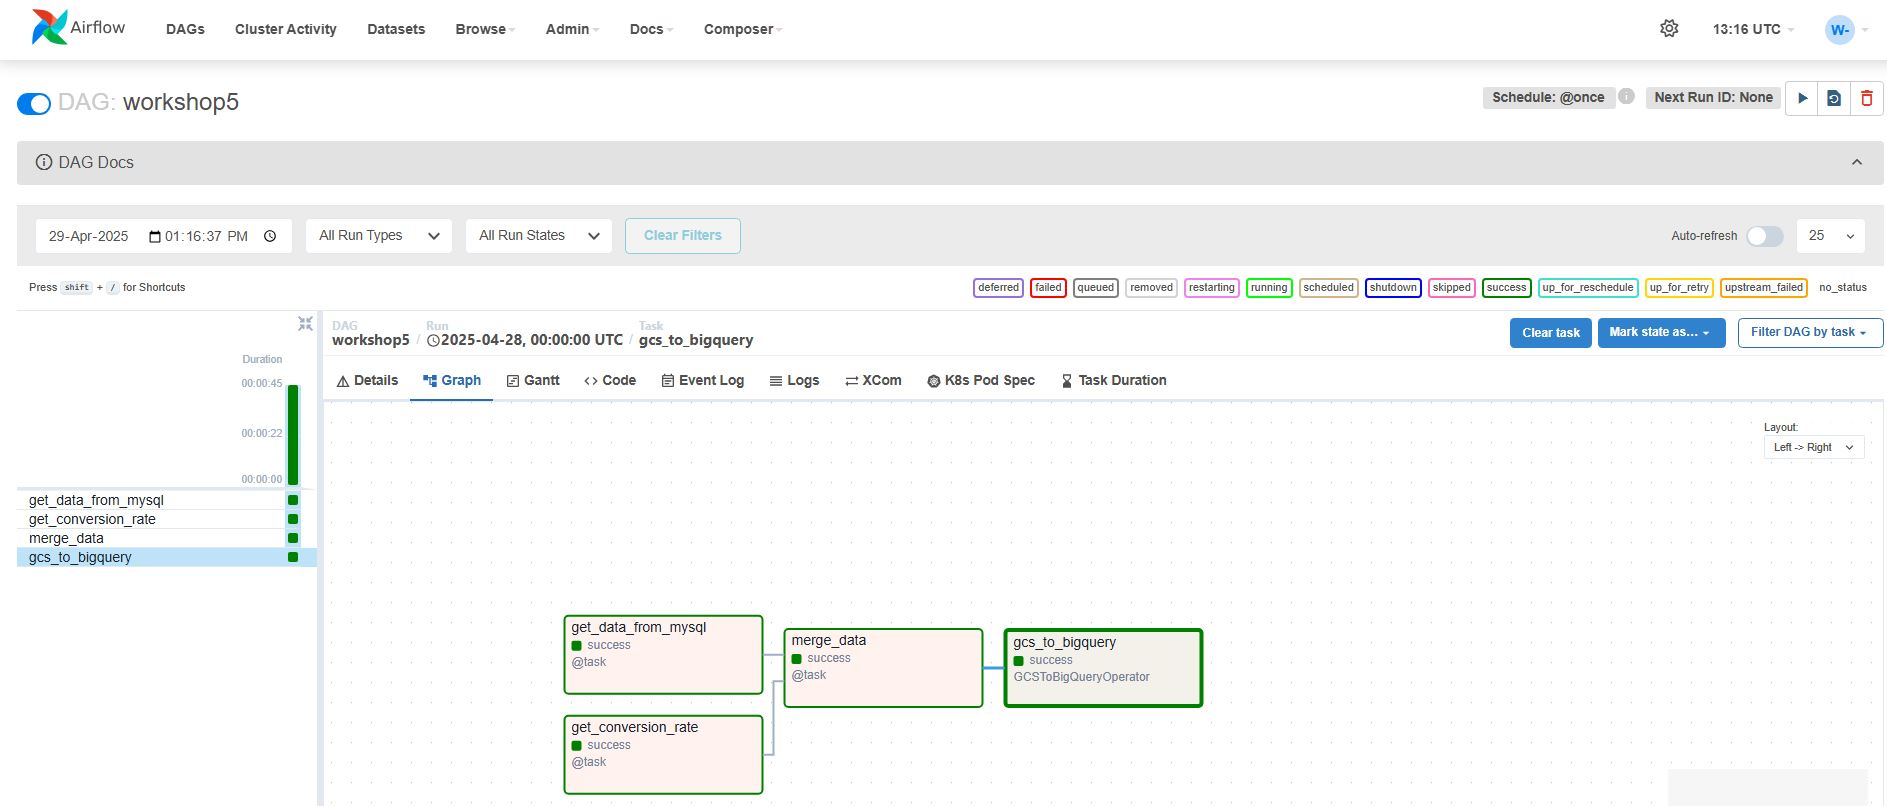

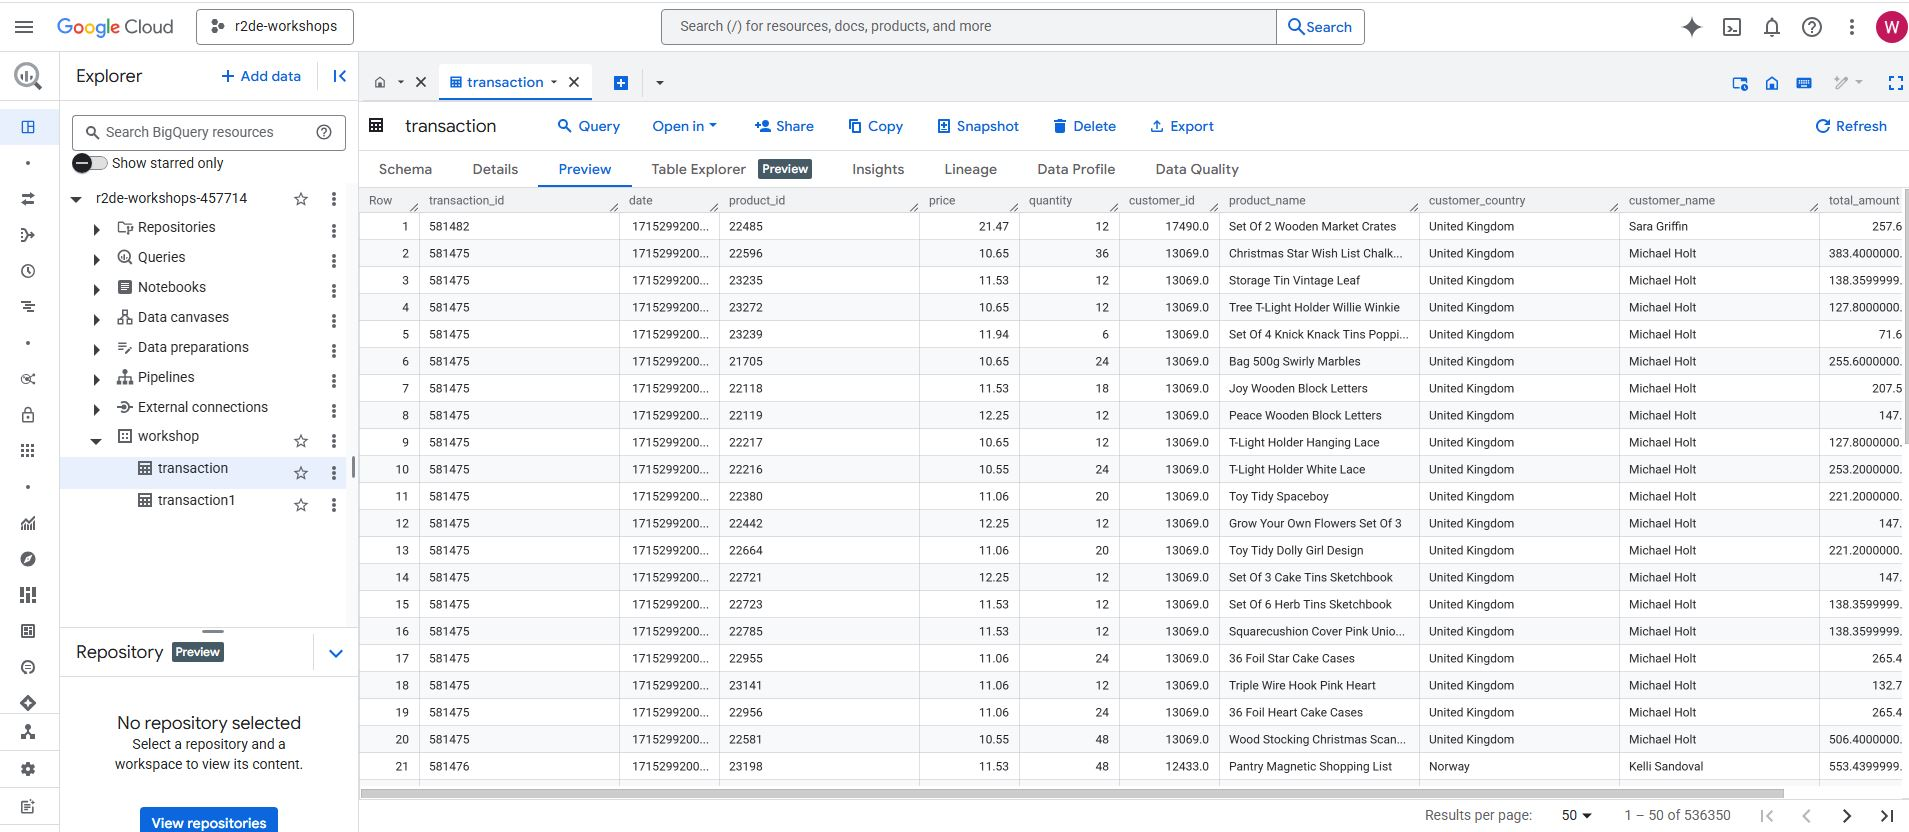

D. Query sum of the daily total thb_amount per date

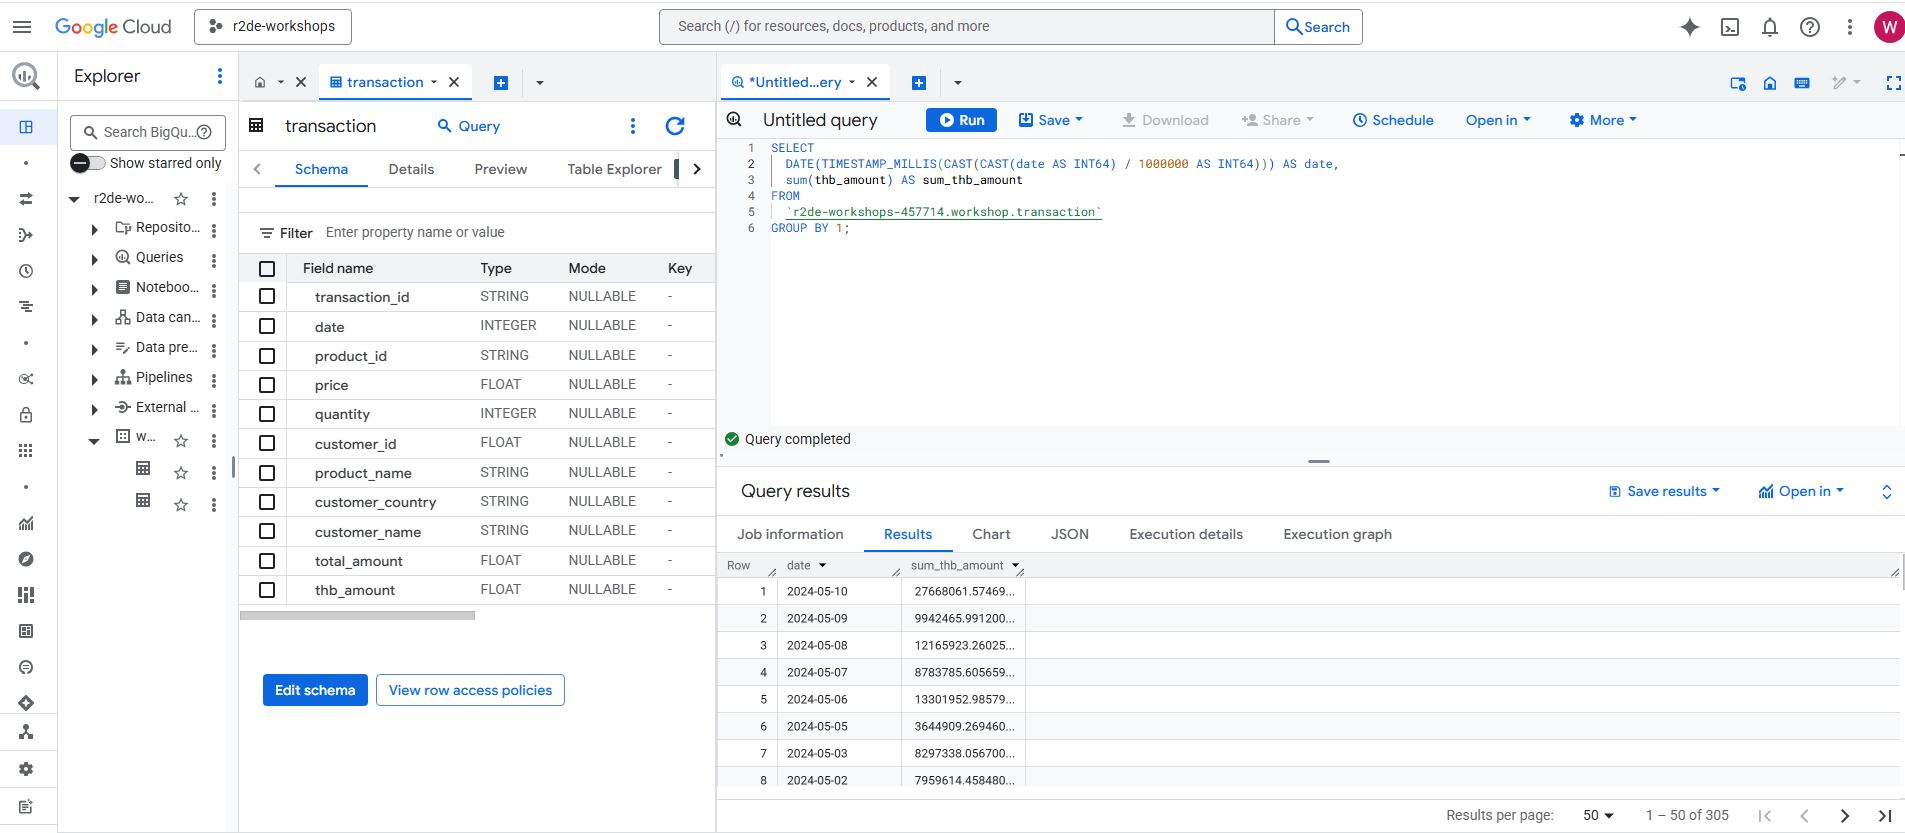

E. Query sum of the daily total thb_amount per date by save view

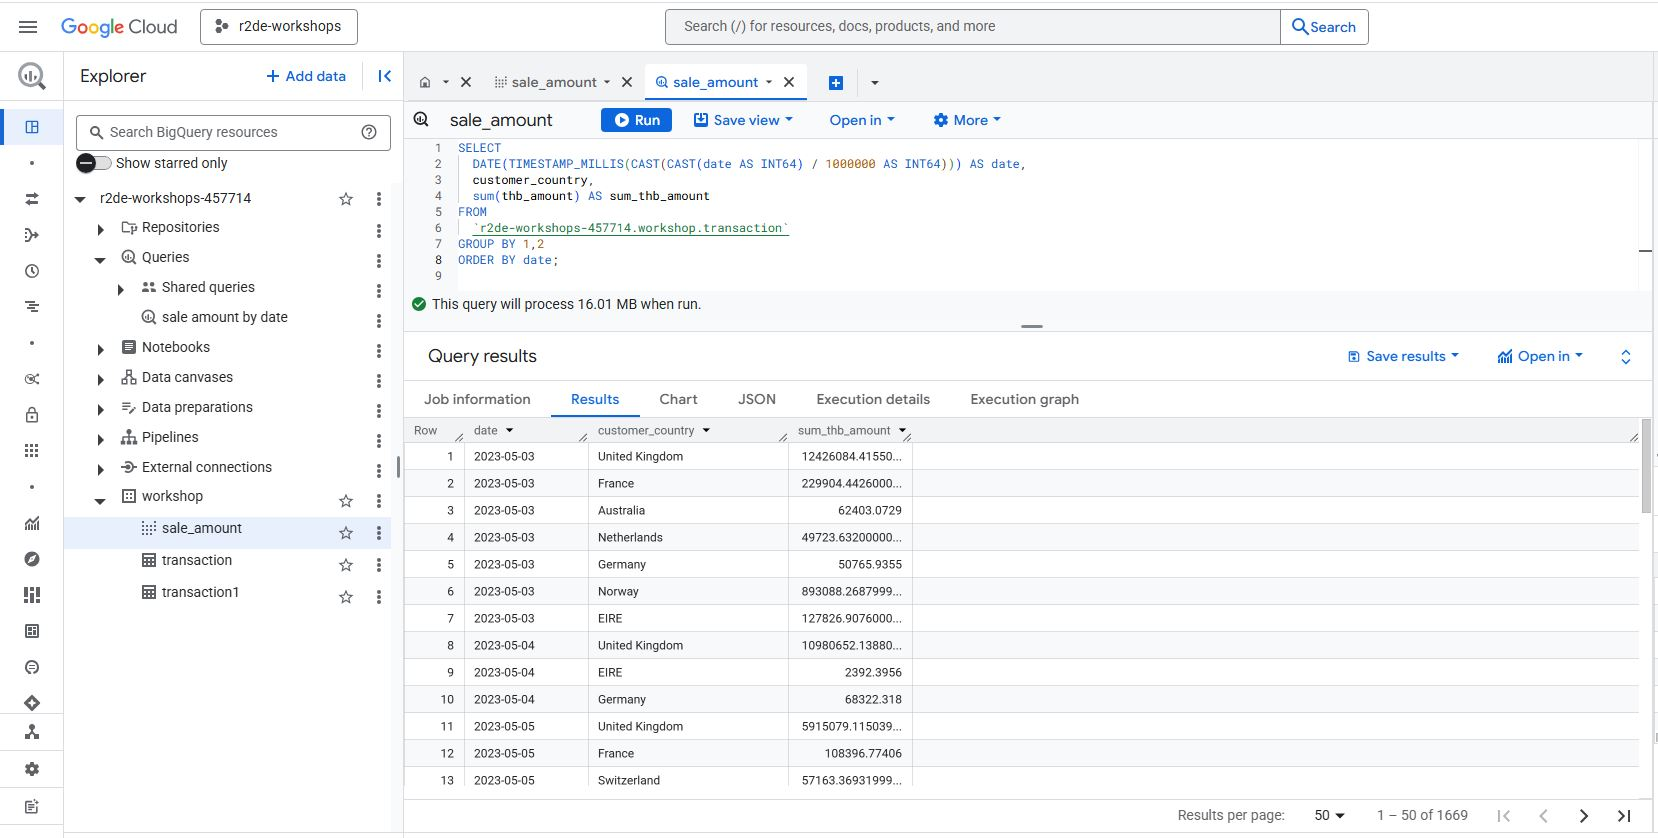